# Hourly time series forecasting using XGBoost

## Outline Version 2

On the previous version of this project I successfully trained a XGBoost regressor on the energy consumption data. During the model's performance analysis I identified some possible improvement points, so on this new version I'm digging further into the data to try creating a more performant model. 

- Outlier analysis
- Lag features (windowing)
- Feature engineering: Add holiday indicator and season variable
- Time series cross validation
- Hyperparameters tuning

## Import dependencies

New: Import USFederalHolidayCalendar for the holiday indicator variable

In [1]:
# Data loading, processing and analysis
import os
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from tqdm import tqdm

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Machine learning
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import itertools

## About the dataset

### PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

## Load the data

In [2]:
current_dir = os.getcwd()
root = os.path.dirname(current_dir)
data_dir = os.path.join(root, 'Data')
data = os.path.join(data_dir, 'AEP_hourly.zip')
df = pd.read_csv(data)
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [3]:
df.shape

(121273, 2)

In [4]:
df.dtypes

Datetime     object
AEP_MW      float64
dtype: object

### Converting the Datetime column to proper data type

In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values('Datetime', ascending=True, inplace=True) # Sorting chronologically

## Plot the data

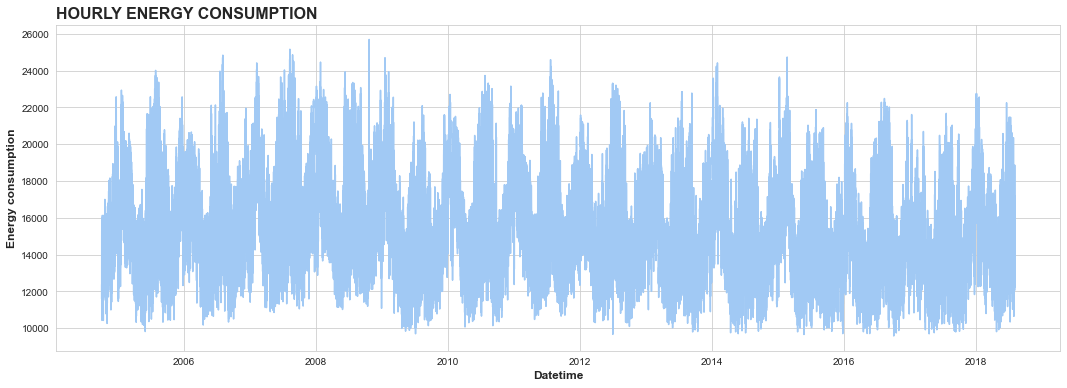

In [6]:
fig, ax = plt.subplots(figsize=(18, 6))
plot = sns.lineplot(x='Datetime',
                    y='AEP_MW',
                    data=df, 
                    ax=ax)
plot.set_ylabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plot.set_xlabel('Datetime', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plot.set_title('Hourly energy consumption'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')
plt.show()

## Train/test split

We're spliting the data to simulate a real-world problem in which we don't know the future. So the training set will be the historical data up to the end of 2014 and the test set will be the remaining "future" data which may also be called as validation set.

In [7]:
split_date = '2015-01-01'
train_set = df.loc[df['Datetime'] < split_date].copy(deep=True) # Good practice to copy the original data instead of editing it inplace
test_set = df.loc[df['Datetime'] >= split_date].copy(deep=True)

### Plot the data

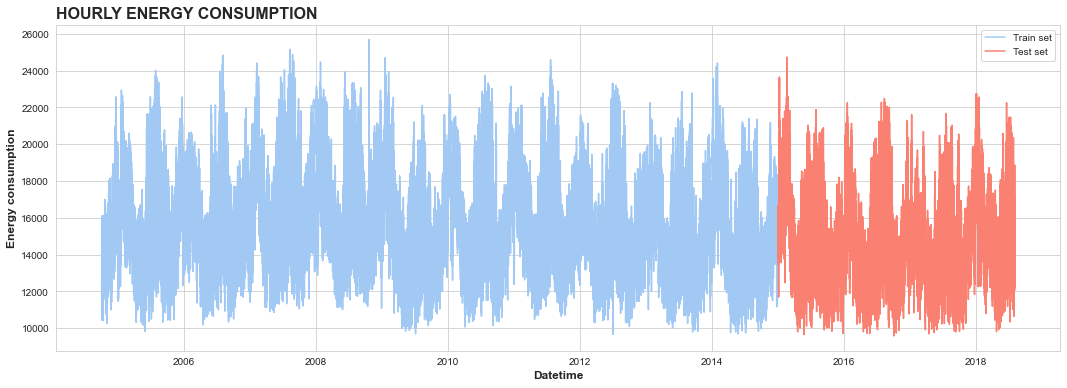

In [8]:
fig, ax = plt.subplots(figsize=(18, 6))
train_plot = sns.lineplot(x='Datetime', y='AEP_MW', data=train_set, label='Train set', ax=ax)
test_plot = sns.lineplot(x='Datetime', y='AEP_MW', data=test_set, label='Test set', color='salmon', ax=ax)
ax.set_ylabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Datetime', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Hourly energy consumption'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')
plt.show()

## Outlier analysis

New: Adding an outlier analysis

### Histogram

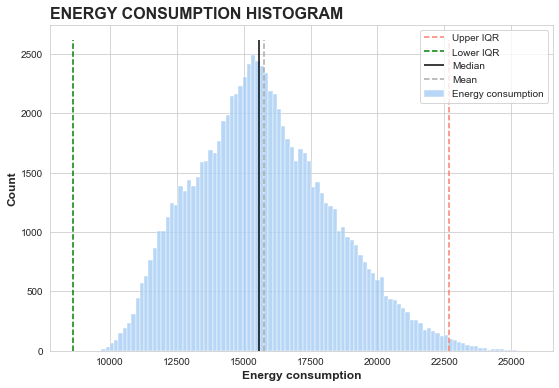

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))

hist = sns.histplot(data=train_set, x='AEP_MW', bins=100, ax=ax, label='Energy consumption')
ax.set_ylabel('Count', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Energy consumption histogram'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')

# Adding IQR ranges to the histogram
q1 = train_set['AEP_MW'].quantile(.25) # First quantile
q3 = train_set['AEP_MW'].quantile(.75) # Third quantile
iqr = q3 - q1
upper_range, lower_range = round(q3 + 1.5*iqr), round(q1 - 1.5*iqr)

ymin, ymax = hist.get_ylim()
hist.vlines(x=upper_range, ymin=ymin, ymax=ymax, color='salmon', linestyle='--', label='Upper IQR')
hist.vlines(x=lower_range, ymin=ymin, ymax=ymax, color='green', linestyle='--', label='Lower IQR')

# Add median and mean
median = train_set['AEP_MW'].median() 
mean = train_set['AEP_MW'].mean()
hist.vlines(x=median, ymin=ymin, ymax=ymax, color='black', linestyle='-', label='Median')
hist.vlines(x=mean, ymin=ymin, ymax=ymax, color='DarkGrey', linestyle='--', label='Mean')

ax.legend()
plt.show()

The mean shifted to the right of the median indicates a positive skewness of the data, which means that the concentrated part of the data is on the left of the median line thus the tail of the distribution is located to the right. The positive skewness also indicates that possible outliers reside on the right side of the distribution so we may focus primarily on understanding the peaks of energy consumption.

### Box-plot

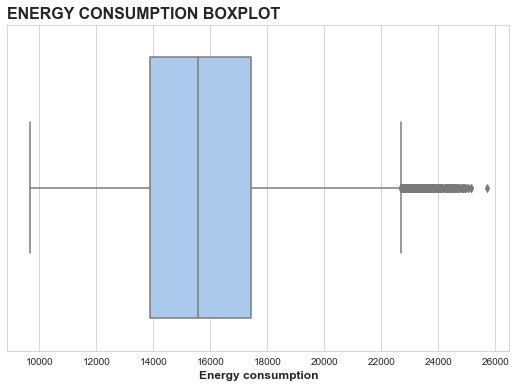

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))

box = sns.boxplot(data=train_set, x='AEP_MW', ax=ax,)
ax.set_xlabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Energy consumption boxplot'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')

plt.show()

As identified on the histogram, the outliers reside on the peaks of energy (marked as black dots). But we can't conclude that all of those data points are infact outliers.

Looks like there are only peaks of energy, thus upper outliers.

In [11]:
n_upper = train_set.loc[train_set['AEP_MW'] > upper_range].shape[0]
n_lower = train_set.loc[train_set['AEP_MW'] < lower_range].shape[0]

print(f'Observations above 1.5IQR ({upper_range}): {n_upper}')
print(f'Observations below 1.5IQR ({lower_range}): {n_lower}')

Observations above 1.5IQR (22690): 528
Observations below 1.5IQR (8618): 0


### Ploting the outliers

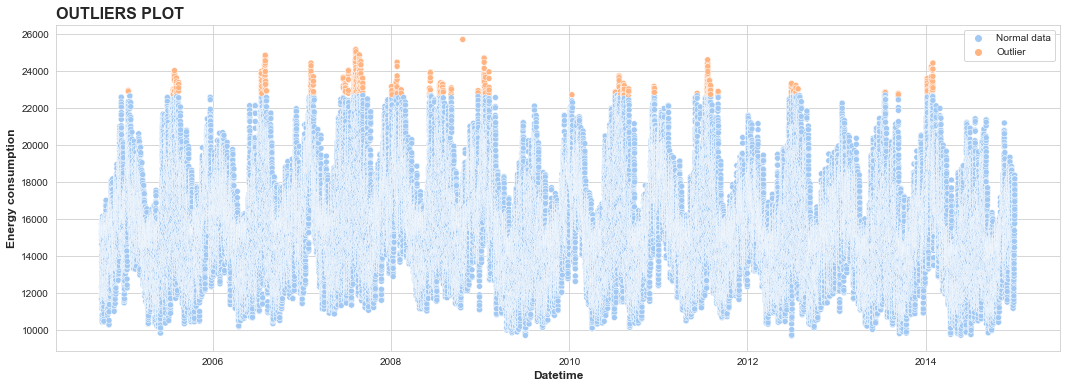

In [12]:
# Selecting the outliers
plot_data = train_set.copy(deep=True)
plot_data['outlier'] = 'Normal data'
plot_data.loc[plot_data['AEP_MW'] > upper_range, 'outlier'] = 'Outlier'

fig, ax = plt.subplots(figsize=(18, 6))
scatter = sns.scatterplot(x='Datetime', y='AEP_MW', hue='outlier', data=plot_data, ax=ax)
ax.set_ylabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Datetime', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Outliers plot'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')
ax.get_legend().set_title('')
plt.show()

From the above plot it seems that the greater peaks of energy may be seasonal and we shouldn't exclude them. Let's analyse into detail the top 3 months to see if there's any pattern.

In [13]:
mask = plot_data['outlier'] == 'Outlier'
g = plot_data[mask].groupby([plot_data['Datetime'].dt.year, plot_data['Datetime'].dt.month,])['outlier'].count().to_frame()
g.index.rename(['year', 'month'], inplace=True)
g.rename(columns={'outlier': 'outlier_count'}, inplace=True)
g.reset_index(inplace=True)
g = g.pivot(index='month', columns='year', values='outlier_count')
g['totals'] = g.sum(axis=1)
g

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,totals
month,,,,,,,,,,,
1,2.0,NaN,NaN,16.0,29.0,1.0,NaN,NaN,NaN,38.0,86.0
2,NaN,NaN,32.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,40.0
6,NaN,NaN,17.0,12.0,NaN,NaN,1.0,7.0,NaN,NaN,37.0
7,15.0,25.0,11.0,17.0,NaN,15.0,44.0,12.0,10.0,NaN,149.0
8,19.0,28.0,103.0,3.0,NaN,23.0,7.0,NaN,NaN,NaN,183.0
9,NaN,NaN,9.0,5.0,NaN,NaN,2.0,NaN,2.0,NaN,18.0
10,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
12,NaN,NaN,NaN,3.0,NaN,11.0,NaN,NaN,NaN,NaN,14.0


So it seems that ou Aug 2007 there has been an increase of energy consumption. Seems fair to investigate and see if there's any findings.

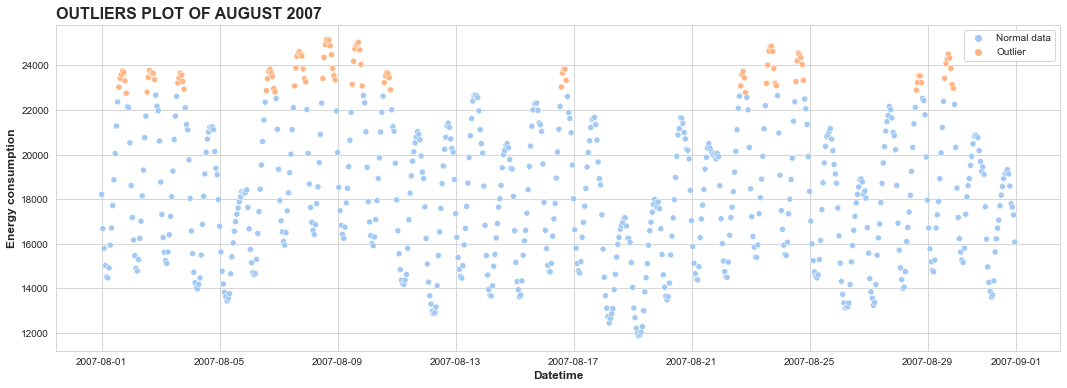

In [14]:
# Fetching the year of 2007 
mask = (plot_data['Datetime'].dt.year == 2007) & (plot_data['Datetime'].dt.month == 8)

fig, ax = plt.subplots(figsize=(18, 6))
scatter = sns.scatterplot(x='Datetime', y='AEP_MW', hue='outlier', data=plot_data[mask], ax=ax)
ax.set_ylabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Datetime', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Outliers plot of August 2007'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')
ax.get_legend().set_title('')
plt.show()

I don't think there's an acceptable explanation to be taken from this data other than there's a chance the increase of energy consumption might be related to an atypical increase of temperature on this month. As august is a summer month so the higher temperatures might have required more airconditioning.

So, I won't be dealing with outliers for the time being since there's no weather date available and later I'll be adding lag features to the data so the removal of outliers might impact other data points that rely on those specific dates to build the lag history (windowing). Let's move on.

## Duplicated instances

New: After revisiting the EDA I found out some Datetime instances are duplicated.

In [15]:
df[df['Datetime'].duplicated(keep=False)]

,Datetime,AEP_MW
82492,2014-11-02 02:00:00,12994.0
82493,2014-11-02 02:00:00,13190.0
91275,2015-11-01 02:00:00,10785.0
91276,2015-11-01 02:00:00,10542.0
99915,2016-11-06 02:00:00,10964.0
99916,2016-11-06 02:00:00,11008.0
108723,2017-11-05 02:00:00,10596.0
108724,2017-11-05 02:00:00,10446.0


In [16]:
print(f'Original row count: {df.shape[0]}')
df = df[df['Datetime'].duplicated() == False]
print(f'After dropping duplicates: {df.shape[0]}')

Original row count: 121273
After dropping duplicates: 121269


In [17]:
df.reset_index(drop=True, inplace=True)
df.head()

,Datetime,AEP_MW
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


## Lag features

Also known as windowing it's adding new features to the data which are the target (y) value (x) hours/days/weeks/months/years before.

**Note**: I was interested at first to lag my data 1, 2 and 3 hours before since it should generate a more accurate output for my target. The main problem with this approach is the fact that I'll only be able to predict as far as **1 hour** (the smallest of the lags) in the future with all my current data.

For instance, let's pretend I'm currently on production. My model was trained with data up to 2022-09-18 18:00:00 (when I'm currently writing this). My next prediction should be for 19:00 hours. That's no problem as the lag features would use data from 18:00, 17:00 and 16:00 hours respectfully. But, what if I want to predict the energy consumption from tomorrow at 19:00? My lag features would be from 2022-09-19 18:00:00, 2022-09-19 17:00:00 and 2022-09-19 16:00:00. That's impossible, because it still hasn't happened.

In [18]:
def create_lag_features(df):
    """
    Creates lag variables from a DataFrame and split into train and test set on the specified date.
    The lags will be 1, 2, and 3 years back in time.
    
    """
    df = df.copy(deep=True)
    df.set_index('Datetime', inplace=True)
    # To move to the year before on the same day and day of the week 
    # subtract 364 days since it's divisible by 7
    for i in range(1, 4):
        lag_df = df.copy(deep=True)
        lag_df.index = lag_df.index + pd.Timedelta(364*i, 'd') # Feedforwarding the lag_df to join a past date to a present one
        lag_df.rename(columns={'AEP_MW': f'lag_{i}'}, inplace=True)
        df = df.join(lag_df[f'lag_{i}'], how='left')
    return df.reset_index()

lag_df = create_lag_features(df)
lag_df.head()

,Datetime,AEP_MW,lag_1,lag_2,lag_3
0,2004-10-01 01:00:00,12379.0,NaN,NaN,NaN
1,2004-10-01 02:00:00,11935.0,NaN,NaN,NaN
2,2004-10-01 03:00:00,11692.0,NaN,NaN,NaN
3,2004-10-01 04:00:00,11597.0,NaN,NaN,NaN
4,2004-10-01 05:00:00,11681.0,NaN,NaN,NaN


In [19]:
lag_df.tail()

,Datetime,AEP_MW,lag_1,lag_2,lag_3
121264,2018-08-02 20:00:00,17673.0,18705.0,20140.0,16078.0
121265,2018-08-02 21:00:00,17303.0,18108.0,19616.0,15908.0
121266,2018-08-02 22:00:00,17001.0,17544.0,19246.0,15783.0
121267,2018-08-02 23:00:00,15964.0,16262.0,17943.0,14808.0
121268,2018-08-03 00:00:00,14809.0,15045.0,16491.0,13669.0


So, the disadvantage of this approach is that there's loss of training data, as my data's earliest year will have missing values since there's no more history to go back to.

That's ok, let's just exclude those observations. The model might still benefit from a more robust feature engineering.

Note: Some instances in the middle of the dataset will also have missing values, because when we went back in time the specific day and hour was not in the dataset.

### Droping missing lag features instances

In [20]:
print(f'Original row count: {lag_df.shape[0]}')
lag_df.dropna(axis=0, inplace=True)
print(f'After dropping nulls: {lag_df.shape[0]}')

Original row count: 121269
After dropping nulls: 95041


## Feature engineering

Adding time series features

New: adding holiday indicator and season variable and refactoring to return a dataframe instead of spliting into X, y.

In [21]:
def add_features(df):
    """
    Creates time series features using the Datetime column.
    
    """   
    df = df.copy(deep=True)
    df['year'] = df['Datetime'].dt.year
    df['quarter'] = df['Datetime'].dt.quarter
    df['month'] = df['Datetime'].dt.month
    df['week_of_year'] = df['Datetime'].dt.isocalendar().week
    df['day_of_year'] = df['Datetime'].dt.dayofyear
    df['day'] = df['Datetime'].dt.day
    df['day_of_week'] = df['Datetime'].dt.dayofweek
    df['hour'] = df['Datetime'].dt.hour
    
    # Season feature
    seasons = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'autumn'} # Seasons mapper
    df['season'] = df['month']%12 // 3 + 1
    
    # Holiday indicator
    cal = calendar()
    holidays = cal.holidays(start=df['Datetime'].min(), end=df['Datetime'].max())
    df['holiday'] = df['Datetime'].isin(holidays)
    df['holiday'] = df['holiday'].map({True: 1,  False: 0}) # Mapping as a numerical feature
    
    # Sorting chronologicaly and reseting the index
    return df.sort_values('Datetime', ascending=True).reset_index(drop=True)

In [22]:
lag_df = add_features(lag_df)
lag_df.head()

,Datetime,AEP_MW,lag_1,lag_2,lag_3,year,quarter,month,week_of_year,day_of_year,day,day_of_week,hour,season,holiday
0,2007-09-28 01:00:00,13821.0,12573.0,12264.0,12379.0,2007,3,9,39,271,28,4,1,4,0
1,2007-09-28 02:00:00,13179.0,12096.0,11690.0,11935.0,2007,3,9,39,271,28,4,2,4,0
2,2007-09-28 03:00:00,12854.0,11850.0,11577.0,11692.0,2007,3,9,39,271,28,4,3,4,0
3,2007-09-28 04:00:00,12692.0,11841.0,11418.0,11597.0,2007,3,9,39,271,28,4,4,4,0
4,2007-09-28 05:00:00,12645.0,12095.0,11556.0,11681.0,2007,3,9,39,271,28,4,5,4,0


## Time series cross validation

New: Add time series cross validation

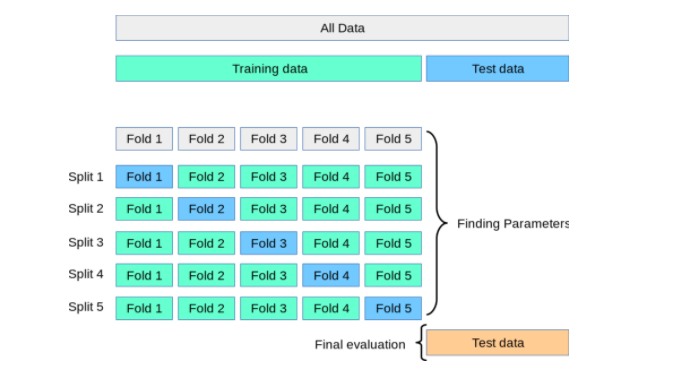

**Why use cross validation?**

On the conventional approach of **train-test split**, when trying to tweak the hyperparameters to achieve a good model performance with the test data, this approach may result in overfitting to the test set. The reason for that is that tweaking the hyperparameters until the estimator performs optimally on the test set will result in *"leakage" of the knowledge about the test set* into the model, thus evaluation metrics won't be reporting generalization performance which is what we want.

**We could use the train/validation/test split then**

Yes. The model's hyperparameters get tunned using a training and validation set. And, finally, the model generalization performance is determined using a test data split. However, this technique also has shortcomings. By partitioning the data into three sets, the number of samples which can be used for learning the model gets reduced and the results depend on a particular random choice for the pair of (train, validation) sets.

### Train-test split for cross validation

We will apply the cross validation to the train set only. The test set will be the last available year of our data with a 24h differece to make sure it's a good split.

In [23]:
end_of_train = lag_df['Datetime'].max() - pd.Timedelta(365, 'd') - pd.Timedelta(24, 'h')
begin_of_test = end_of_train + pd.Timedelta(24, 'h')

train_set, test_set = lag_df[lag_df['Datetime'] <= end_of_train], lag_df[lag_df['Datetime'] >= begin_of_test]
print(train_set.shape)
print(test_set.shape)

(86259, 15)
(8759, 15)


In [24]:
n_splits = 5
split = TimeSeriesSplit(n_splits=n_splits,
                        test_size=365*24, # We want to predict 1 hour into the future and our data is hourly
                        gap=24) # Setting a "gap" of 24h between the train and test data.

### Visualizing the folds

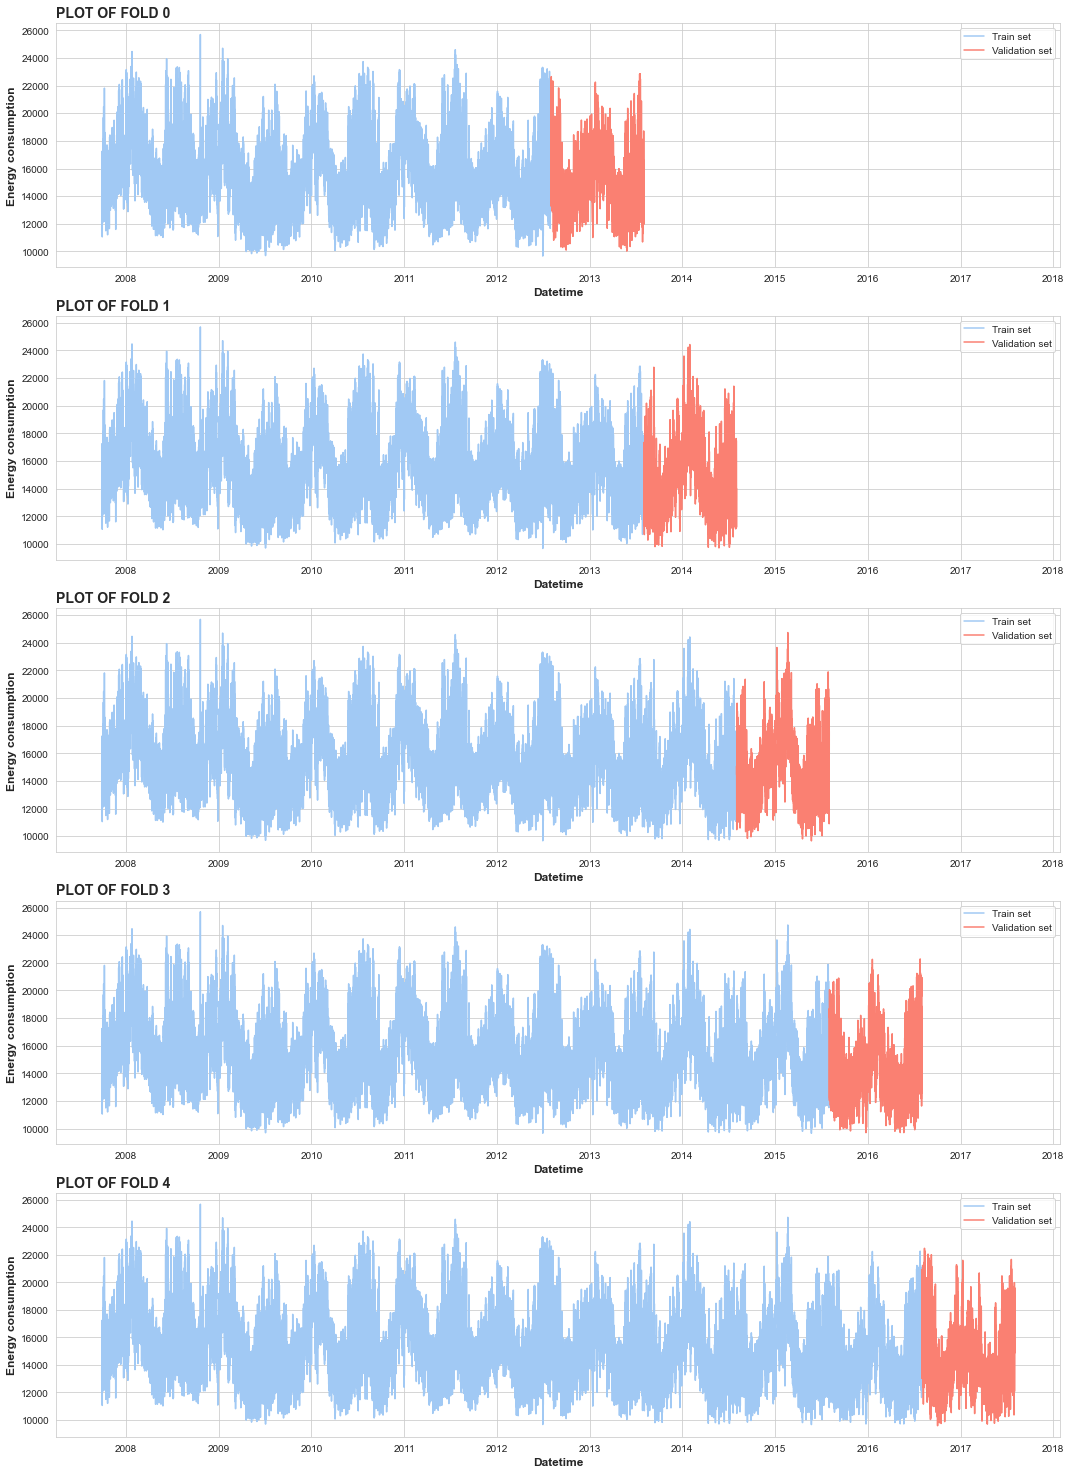

In [25]:
fig, axes = plt.subplots(nrows=n_splits,
                         figsize=(18, 26))

for i, (train_idx, val_idx) in enumerate(split.split(train_set)):
    ax = axes[i]
    train_plot = sns.lineplot(x='Datetime', y='AEP_MW', data=train_set.loc[train_idx], label='Train set', ax=ax)
    val_plot = sns.lineplot(x='Datetime', y='AEP_MW', data=train_set.loc[val_idx], label='Validation set', color='salmon', ax=ax)
    ax.set_ylabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_xlabel('Datetime', fontdict={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_title(f'Plot of fold {i}'.upper(), fontdict={'fontsize': 14, 'fontweight': 'bold'}, loc='left')
    # set x axis limits to visualize the splits
    ax.set_xlim(left=train_set['Datetime'].min() - pd.Timedelta(180, 'd'), # Subtracting half year to centralize the plot
                right=train_set['Datetime'].max() + pd.Timedelta(180, 'd'))

plt.show()

## Training our model

We're using the XGBoost model

New: Wrapping the training process using cross validation into a function to be used during the hyperparameters tuning part.

In [26]:
def train_xgboost(data, model, n_splits=5, verbose=100):
    """
    Fits the model to the data using cross validation and returns a dictionary of scores for each fold.
    
    """
    FEATURES = ['year', 'quarter', 'month', 'week_of_year', 
                'day_of_year', 'day', 'day_of_week', 'hour',
                'season', 'holiday', 'lag_1', 'lag_2', 'lag_3']
    TARGET = ['AEP_MW']

    split = TimeSeriesSplit(n_splits=n_splits,
                            test_size=365*24, # We want to predict 1 hour into the future and our data is hourly
                            gap=24) # Setting a "gap" of 24h between the train and test data.
    scores = {}
    # For loop of the cross validation
    for i, (train_idx, val_idx) in enumerate(split.split(data)):
        train = data.loc[train_idx]
        val = data.loc[val_idx]

        X_train, y_train = train[FEATURES].values, train[TARGET].values
        X_val, y_val = val[FEATURES].values, val[TARGET].values

        evaluation_set = [(X_train, y_train), (X_val, y_val)]

        # Fitting the model
        if verbose:
            print(f'Fitting the model for the fold {i}')
        model.fit(X_train, y_train, eval_set=evaluation_set, verbose=verbose)

        # Making predictions on both train and validation set
        y_pred = model.predict(X_val)
        mae = np.mean(np.abs(y_val - y_pred))
        mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
        rmse = np.sqrt(mse)

        # Storing the evaluation metrics
        scores[f'fold_{i}'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
        
    return scores

# Instantiating our model
# Note that the fit method will re-fit the model from scratch unless the 
# 'xgb_model' argument is given
reg = xgb.XGBRegressor(n_estimators=1000,
                       max_depth=10,
                       learning_rate=0.01,
                       early_stopping_rounds=50, # Prevents the model to overfit the training data
                       random_state=123,)

scores = train_xgboost(data=train_set, 
                       model=reg,
                       n_splits=5,
                       verbose=100)

Fitting the model for the fold 0
[0]	validation_0-rmse:15932.10074	validation_1-rmse:15298.65437
[100]	validation_0-rmse:5950.76424	validation_1-rmse:5577.09969
[200]	validation_0-rmse:2341.91983	validation_1-rmse:2355.27228
[300]	validation_0-rmse:1091.35304	validation_1-rmse:1617.76586
[400]	validation_0-rmse:698.18312	validation_1-rmse:1541.88868
[441]	validation_0-rmse:633.15487	validation_1-rmse:1545.79637
Fitting the model for the fold 1
[0]	validation_0-rmse:15827.17306	validation_1-rmse:15271.28415
[100]	validation_0-rmse:5914.46447	validation_1-rmse:5869.25979
[200]	validation_0-rmse:2340.51696	validation_1-rmse:2763.44008
[300]	validation_0-rmse:1115.87663	validation_1-rmse:1907.80245
[400]	validation_0-rmse:738.18835	validation_1-rmse:1701.53943
[500]	validation_0-rmse:611.66403	validation_1-rmse:1645.85947
[600]	validation_0-rmse:542.78973	validation_1-rmse:1635.71967
[700]	validation_0-rmse:497.84205	validation_1-rmse:1635.16561
[710]	validation_0-rmse:494.27230	validation

### Cross validation results

In [27]:
def cv_score(scores):
    """
    Returns the mean scores of the cross validation.
    
    """
    mean_dict = {'MAE': 0, 'MSE': 0, 'RMSE': 0}
    for k, v in scores.items():
        for metric, val in v.items():
            mean_dict[metric] += val/len(scores) # Take the average
    return mean_dict
cv_score(scores)

{'MAE': 2641.5109868295194,
 'MSE': 2608548.5612036004,
 'RMSE': 1611.5735050580165}

In [28]:
def display_scores(scores):
    """
    Returns a DataFrame with the cross validation error metrics and the mean result.
    
    """
    score_df = pd.DataFrame(scores).T
    score_df.loc['Mean', :] = score_df.mean(axis=0)
    return score_df
display_scores(scores)

,MAE,MSE,RMSE
fold_0,2526.780795,2.375170e+06,1541.158649
fold_1,2652.524284,2.670283e+06,1634.099995
fold_2,2736.099598,2.197610e+06,1482.433955
fold_3,2615.329518,2.567693e+06,1602.402164
fold_4,2676.820740,3.231987e+06,1797.772762
Mean,2641.510987,2.608549e+06,1611.573505


## Hyperparameters tuning

For the hyperparameters tuning we will be performing an exaustive seach of a pool of combinations of hyperparameters. This is similar to using the GridSearchCV class of sklearn.

New: Add hyperparameters tunning

### Search space

In [29]:
params = {'max_depth': [3, 6, 10],
          'learning_rate': [0.01, 0.05, 0.1],
          'n_estimators': [100, 500, 1000],
          'colsample_bytree': [0.3, 0.7]}

# Creating the hyperparameters search space by permutating the params dict
keys, values = zip(*params.items())
search_space = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f'Amount of combinations: {len(search_space)}')
search_space[:3]

Amount of combinations: 54


[{'max_depth': 3,
  'learning_rate': 0.01,
  'n_estimators': 100,
  'colsample_bytree': 0.3},
 {'max_depth': 3,
  'learning_rate': 0.01,
  'n_estimators': 100,
  'colsample_bytree': 0.7},
 {'max_depth': 3,
  'learning_rate': 0.01,
  'n_estimators': 500,
  'colsample_bytree': 0.3}]

### Run the experiments

In [30]:
for hyperparams in tqdm(search_space): # Add progress bar
    # Instantiate the model
    reg = xgb.XGBRegressor(**hyperparams, # Introduce the params as a kwargs argument
                           early_stopping_rounds=10,
                           random_state=123,)

    # Train the model using cross-validation and get the scores
    scores = train_xgboost(data=train_set, 
                           model=reg,
                           n_splits=5,
                           verbose=0)
    
    # Update the search space list of dicts 
    hyperparams.update(cv_score(scores))

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [21:54<00:00, 24.34s/it]


### Display the results to a dataframe

In [31]:
search_results = pd.DataFrame.from_dict(search_space)
search_results

,max_depth,learning_rate,n_estimators,colsample_bytree,MAE,MSE,RMSE
0,3,0.01,100,0.3,5243.730039,3.068722e+07,5535.465493
1,3,0.01,100,0.7,5316.235859,3.114102e+07,5576.558532
2,3,0.01,500,0.3,2514.819264,2.334443e+06,1525.268760
3,3,0.01,500,0.7,2554.101386,2.380901e+06,1541.168129
4,3,0.01,1000,0.3,2518.160970,2.330847e+06,1524.016763
5,3,0.01,1000,0.7,2573.086973,2.322700e+06,1522.842834
6,3,0.05,100,0.3,2527.447381,2.358906e+06,1533.006071
7,3,0.05,100,0.7,2559.696453,2.386263e+06,1542.755736
8,3,0.05,500,0.3,2531.309819,2.354454e+06,1531.462521
9,3,0.05,500,0.7,2587.424815,2.304227e+06,1516.738846


In [32]:
search_results.sort_values(by='RMSE', ascending=True).head()

,max_depth,learning_rate,n_estimators,colsample_bytree,MAE,MSE,RMSE
22,6,0.01,1000,0.3,2559.415805,2.289736e+06,1511.097220
20,6,0.01,500,0.3,2557.580071,2.291259e+06,1511.635839
16,3,0.10,1000,0.3,2564.283750,2.295073e+06,1514.155868
14,3,0.10,500,0.3,2564.283750,2.295073e+06,1514.155868
40,10,0.01,1000,0.3,2576.818228,2.298389e+06,1514.544161


- On the model build on version 1 of this notebook we obtained a RSME of 1653.
- On this version, after analysing outliers, adding new features and using cross-validation we obtained a RSME of 1612. That's a 3% error reduction, which is good.
- Lastly, after trying to search for the best hyperparameters as well as using cross-validation we obtained a RSME of 1511 which is a 9% decrease of the first model and a 6.3% decrease from the second model.

There's even more room for improvement using other hyperparameters tuning techniques such as bayesian optimization or even tweaking other hyperparameters using exaustive search as we just did.

## Final model evaluation

We used cross-validation to train the model so the training data was split into train and validation, which is used for hyperparameters tuning without leaking knowledge about the test set into the model. So now we need to retrain the chosen model with the whole train set, without spliting it into K-folds, and lastly evaluate its performance using the test set which we left untouched so far during the training stage.

### Get best hyperparameters

In [33]:
best_params = search_results.sort_values(by='RMSE', ascending=True).head(1)[['max_depth', 'learning_rate', 'n_estimators', 'colsample_bytree']].to_dict(orient='records')[0]
best_params

{'max_depth': 6,
 'learning_rate': 0.01,
 'n_estimators': 1000,
 'colsample_bytree': 0.3}

### Train the final model

In [34]:
reg = xgb.XGBRegressor(**best_params,
                       early_stopping_rounds=10,
                       random_state=123,)

# Split the data into X and y
X_train, y_train = train_set.drop(columns=['Datetime', 'AEP_MW']).values, train_set['AEP_MW'].values
X_test, y_test = test_set.drop(columns=['Datetime', 'AEP_MW']).values, test_set['AEP_MW'].values
evaluation_set = [(X_train, y_train), (X_test, y_test)]

# Train the final model once more and evaluate the performance using the test set
reg.fit(X_train, y_train, eval_set=evaluation_set, verbose=10)

[0]	validation_0-rmse:15466.38696	validation_1-rmse:15012.08204
[10]	validation_0-rmse:14009.14599	validation_1-rmse:13625.64311
[20]	validation_0-rmse:12693.26792	validation_1-rmse:12355.64254
[30]	validation_0-rmse:11502.15737	validation_1-rmse:11215.11353
[40]	validation_0-rmse:10427.20759	validation_1-rmse:10192.50915
[50]	validation_0-rmse:9456.80571	validation_1-rmse:9264.94142
[60]	validation_0-rmse:8581.31182	validation_1-rmse:8425.16855
[70]	validation_0-rmse:7789.41056	validation_1-rmse:7688.60333
[80]	validation_0-rmse:7076.72511	validation_1-rmse:6998.39860
[90]	validation_0-rmse:6433.55721	validation_1-rmse:6386.02085
[100]	validation_0-rmse:5853.67088	validation_1-rmse:5834.06586
[110]	validation_0-rmse:5332.00903	validation_1-rmse:5342.82243
[120]	validation_0-rmse:4863.66611	validation_1-rmse:4900.68051
[130]	validation_0-rmse:4444.74342	validation_1-rmse:4511.43184
[140]	validation_0-rmse:4067.59260	validation_1-rmse:4156.73209
[150]	validation_0-rmse:3730.08510	valida

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [35]:
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_true=y_test,
                         y_pred=y_pred)
rmse = np.sqrt(mse)
rmse

1624.0971913034

So we got a RMSE of 1624 for the final model which is a 2% improvement in respect to the version 1's model. This may be a little but on a regression problem depending of the nature of the business this might impact a lot on savings or overall company's performance. So any improvement matters.

But... Wait... This final model seems to have performed worse than the first model we build on this version. Let's recall: The [first model of this version](#Training-our-model) got a RSME of 1612, while we have a final RMSE of 1624. Seems like there's a problem... 

Actually no, because we're comparing the the **mean cross-validation RSME** with the real RMSE obtained using the test set after retraining the model on the whole train set. Well, let's dig further into this and train the first model of this notebook using the whole train set and evaluating the real RMSE using the test set.

In [36]:
reg1 = xgb.XGBRegressor(n_estimators=1000,
                        max_depth=10,
                        learning_rate=0.01,
                        early_stopping_rounds=50,
                        random_state=123,)

reg1.fit(X_train, y_train, eval_set=evaluation_set, verbose=None)

y_pred = reg1.predict(X_test)
mse = mean_squared_error(y_true=y_test,
                         y_pred=y_pred)
rmse = np.sqrt(mse)
rmse

1811.5024166063797

Well... Seems the mystery was solved and hyperparameters tuning is actually a thing that works. 

Finally, let's add a section on predicting the future using the final model.

## Predicting the future

New: Simulating a production scenery in which we use the final model to predict the future.

### Skeleton data

We need to build a datetime skeleton of the future, apply all our data cleaning and feature engineering functions and finally use the best model to infer about the future consumption of energy.

In [37]:
# Get the last date available and add a 24h gap
last_date = df['Datetime'].max()
future_date = last_date + pd.Timedelta(24, 'h')

# Create a hourly dataframe with 1 year period since our smallest lag feature is a year time
# Adding 364-1 days to account for the 24h gap above
future_df = pd.DataFrame({'Datetime': pd.date_range(start=future_date,
                                                    end=future_date + pd.Timedelta(363, 'd'),
                                                    freq='h')}) # Hourly frequency
future_df.head()

,Datetime
0,2018-08-04 00:00:00
1,2018-08-04 01:00:00
2,2018-08-04 02:00:00
3,2018-08-04 03:00:00
4,2018-08-04 04:00:00


In [38]:
future_df.tail()

,Datetime
8708,2019-08-01 20:00:00
8709,2019-08-01 21:00:00
8710,2019-08-01 22:00:00
8711,2019-08-01 23:00:00
8712,2019-08-02 00:00:00


In [39]:
future_df.shape

(8713, 1)

In [40]:
# To apply our lag features function we need to concat the future data with the historic data
# Create a flag column to identify the future data easily
future_df['is_future'] = 1
future_df = pd.concat([future_df, df], axis=0, ignore_index=True)
future_df['is_future'].fillna(0, inplace=True) # Fillna for historic data
future_df.head()

,Datetime,is_future,AEP_MW
0,2018-08-04 00:00:00,1.0,NaN
1,2018-08-04 01:00:00,1.0,NaN
2,2018-08-04 02:00:00,1.0,NaN
3,2018-08-04 03:00:00,1.0,NaN
4,2018-08-04 04:00:00,1.0,NaN


### Data pipeline

In [41]:
future_df = (future_df.pipe(create_lag_features).pipe(add_features))
future_df.head()

,Datetime,is_future,AEP_MW,lag_1,lag_2,lag_3,year,quarter,month,week_of_year,day_of_year,day,day_of_week,hour,season,holiday
0,2004-10-01 01:00:00,0.0,12379.0,NaN,NaN,NaN,2004,4,10,40,275,1,4,1,4,0
1,2004-10-01 02:00:00,0.0,11935.0,NaN,NaN,NaN,2004,4,10,40,275,1,4,2,4,0
2,2004-10-01 03:00:00,0.0,11692.0,NaN,NaN,NaN,2004,4,10,40,275,1,4,3,4,0
3,2004-10-01 04:00:00,0.0,11597.0,NaN,NaN,NaN,2004,4,10,40,275,1,4,4,4,0
4,2004-10-01 05:00:00,0.0,11681.0,NaN,NaN,NaN,2004,4,10,40,275,1,4,5,4,0


In [42]:
future_df.tail()

,Datetime,is_future,AEP_MW,lag_1,lag_2,lag_3,year,quarter,month,week_of_year,day_of_year,day,day_of_week,hour,season,holiday
129977,2019-08-01 20:00:00,1.0,NaN,17673.0,18705.0,20140.0,2019,3,8,31,213,1,3,20,3,0
129978,2019-08-01 21:00:00,1.0,NaN,17303.0,18108.0,19616.0,2019,3,8,31,213,1,3,21,3,0
129979,2019-08-01 22:00:00,1.0,NaN,17001.0,17544.0,19246.0,2019,3,8,31,213,1,3,22,3,0
129980,2019-08-01 23:00:00,1.0,NaN,15964.0,16262.0,17943.0,2019,3,8,31,213,1,3,23,3,0
129981,2019-08-02 00:00:00,1.0,NaN,14809.0,15045.0,16491.0,2019,3,8,31,214,2,4,0,3,0


### Checking for future days with gap on any lag feature

In [43]:
future_df.loc[(future_df[['lag_1', 'lag_2', 'lag_3']].isnull().any(axis='columns')) &
              (future_df['is_future'] == 1)]

,Datetime,is_future,AEP_MW,lag_1,lag_2,lag_3,year,quarter,month,week_of_year,day_of_year,day,day_of_week,hour,season,holiday
126504,2019-03-10 03:00:00,1.0,NaN,NaN,NaN,NaN,2019,1,3,10,69,10,6,3,2,0


In [44]:
# Selecting the future only after introducing the variables
future_df = future_df.loc[future_df['is_future'] == 1]
# Dropping the target col and flag column
future_df.drop(columns=['is_future', 'AEP_MW'], inplace=True)
print(f'Future dataframe rows: {future_df.shape[0]}')
# Dropping rows with nan
future_df.dropna(axis=0, inplace=True)
print(f'Future dataframe rows after dropping na: {future_df.shape[0]}')

Future dataframe rows: 8713
Future dataframe rows after dropping na: 8712


Everything seems ok. Only 1 row dropped as we checked before. Looks like we won't have predictions for this hour.

### Making predictions

In [45]:
future_df['AEP_MW'] = reg.predict(future_df.drop(columns=['Datetime']).values)

In [46]:
future_df.head()

,Datetime,lag_1,lag_2,lag_3,year,quarter,month,week_of_year,day_of_year,day,day_of_week,hour,season,holiday,AEP_MW
121269,2018-08-04 00:00:00,12732.0,16239.0,14087.0,2018,3,8,31,216,4,5,0,3,0,13985.859375
121270,2018-08-04 01:00:00,11870.0,15083.0,13056.0,2018,3,8,31,216,4,5,1,3,0,12990.416016
121271,2018-08-04 02:00:00,11339.0,14297.0,12322.0,2018,3,8,31,216,4,5,2,3,0,12362.272461
121272,2018-08-04 03:00:00,10838.0,13594.0,11928.0,2018,3,8,31,216,4,5,3,3,0,11971.629883
121273,2018-08-04 04:00:00,10639.0,13257.0,11701.0,2018,3,8,31,216,4,5,4,3,0,11704.027344


### Future data plot

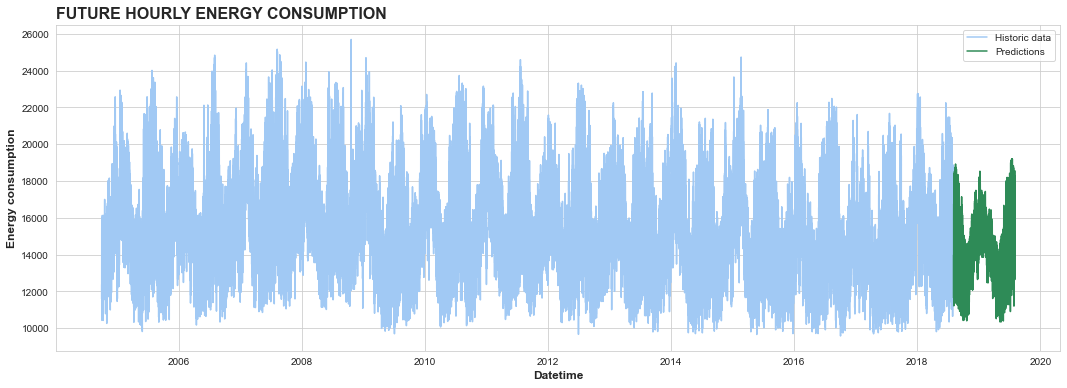

In [47]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(x='Datetime', y='AEP_MW', data=df, label='Historic data', ax=ax)
sns.lineplot(x='Datetime', y='AEP_MW', data=future_df, label='Predictions', color='seagreen', ax=ax)
ax.set_ylabel('Energy consumption', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Datetime', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Future hourly energy consumption'.upper(), fontdict={'fontsize': 16, 'fontweight': 'bold'}, loc='left')
plt.show()

### Final considerations

We've added new features to the data and created an outliers analysis section. We've then stressed the training phase by using more robust techniques such as cross-validation, to prevent test data leakage to the model, and hyperparameters tuning using an exhaustive search over a grid of parameters values. The best hyperparameters values list was selected and the production model was trained using all the train data. The model's performance was tested using the unseen test set and it has been seen that the hyperparameters tuning stage in fact works to improve the model's overall performance. Finally we created a skeleton data using our pipeline and used the model to predict the future.